# Comparative Analysis of Anomaly Detection Models

## Objective
To compare three unsupervised anomaly detection models—**DBSCAN**, **Isolation Forest**, and **K-Means**—identifying unusual fluctuations in monthly tourism arrival data. This notebook evaluates their performance based on detection accuracy, false alarms, and stability.

## Dataset
- **Source**: Tourism Arrivals Data
- **Anomaly Definition**: COVID-19 Period (March 2020 - April 2022) is treated as the "Ground Truth" anomaly period because it represents a structural break in the trend.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Load Data
df = pd.read_csv('arrivals (1).csv')
df['date'] = pd.to_datetime(df['date'])
df_total = df[df['country'] == 'ALL'].copy()
df_total = df_total.sort_values('date').set_index('date')

# Define Ground Truth (COVID-19 Impact)
covid_start = pd.to_datetime('2020-03-01')
covid_end = pd.to_datetime('2022-04-01')
df_total['ground_truth'] = 0
df_total.loc[(df_total.index >= covid_start) & (df_total.index <= covid_end), 'ground_truth'] = 1

# Preprocessing
X = df_total[['arrivals']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Total Months: {len(df_total)}")
print(f"Anomalies (COVID months): {df_total['ground_truth'].sum()}")
print(f"Anomaly Ratio: {df_total['ground_truth'].mean():.2%}")

Total Months: 58
Anomalies (COVID months): 26
Anomaly Ratio: 44.83%


## 1. Unsupervised Models Implementation

### Model A: DBSCAN
Density-Based Spatial Clustering of Applications with Noise. Points in low-density regions are marked as outliers (-1).
- **Eps**: 0.25 (tuned distance threshold)
- **Min Samples**: 4

In [11]:
# Model A: DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=4)
labels_db = dbscan.fit_predict(X_scaled)
# -1 is anomaly, rest are clusters
pred_db = np.where(labels_db == -1, 1, 0)

### Model B: Isolation Forest (Unsupervised)
Isolates observations by randomly selecting a feature and then randomly selecting a split value. Anomalies are isolated faster (shorter path length).
- **Contamination**: 0.45 (Assuming we know the approx ratio, otherwise it defaults to auto/0.1)

In [12]:
# Model B: Isolation Forest (Unsupervised)
iso_unsupervised = IsolationForest(contamination=0.45, random_state=42)
pred_iso_unsup = iso_unsupervised.fit_predict(X)
# -1 is anomaly
pred_iso_unsup = np.where(pred_iso_unsup == -1, 1, 0)

### Model C: K-Means Clustering
K-Means partitions data into K clusters. We treat the smaller or lower-value cluster as the "Anomaly" regime, or check distance to centroids.
- **K**: 2 (Normal vs COVID regime)

In [14]:
# Model C: K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

# Identify which cluster is the "Anomaly" (lower arrivals)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_means = [centers[0][0], centers[1][0]]
# The cluster with lower mean arrival is the anomaly/COVID period
normal_cluster = 1 if cluster_means[1] > cluster_means[0] else 0
anomaly_cluster = 1 - normal_cluster

pred_km = np.where(labels_km == anomaly_cluster, 1, 0)

## 2. Advanced Approach: Semi-Supervised Isolation Forest
**Strategy**: Train ONLY on Normal data (Pre-COVID & Post-COVID). Test on the full dataset. This treats the problem as **Novelty Detection** rather than Outlier Detection.

In [15]:
# Semi-Supervised Isolation Forest
train_data = df_total[df_total['ground_truth'] == 0].copy()
X_train = train_data[['arrivals']].values

# Train on Normal Data only (Contamination is low in training set)
iso_semi = IsolationForest(contamination=0.01, random_state=42)
iso_semi.fit(X_train)

pred_iso_semi_raw = iso_semi.predict(X)
pred_iso_semi = np.where(pred_iso_semi_raw == -1, 1, 0)

## 3. Results & Evaluation

In [20]:
# Print Comparison Table
print(f"{'Model':<30} | {'F1':<6} | {'Prec':<6} | {'Rec':<6} | {'Acc':<6} | {'TN':<4} {'FP':<4} {'FN':<4} {'TP':<4}")
print("-" * 95)

results = []
for name, preds in models.items():
    # Summary Table Metrics
    f1 = f1_score(df_total['ground_truth'], preds)
    prec = precision_score(df_total['ground_truth'], preds)
    rec = recall_score(df_total['ground_truth'], preds)
    acc = np.mean(preds == df_total['ground_truth'])
    tn, fp, fn, tp = confusion_matrix(df_total['ground_truth'], preds).ravel()
    
    results.append({'Model': name, 'F1': f1, 'Precision': prec, 'Recall': rec, 'Accuracy': acc, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
    print(f"{name:<30} | {f1:.3f}  | {prec:.3f}  | {rec:.3f}  | {acc:.3f}  | {tn:<4} {fp:<4} {fn:<4} {tp:<4}")

# Print Detailed Reports
print("\n" + "="*40)
print("DETAILED CLASSIFICATION REPORTS")
print("="*40)

for name, preds in models.items():
    print(f"\n--- {name} Evaluation ---")
    print(classification_report(df_total['ground_truth'], preds))
    print("Confusion Matrix:")
    print(confusion_matrix(df_total['ground_truth'], preds))
    print("-" * 40)

Model                          | F1     | Prec   | Rec    | Acc    | TN   FP   FN   TP  
-----------------------------------------------------------------------------------------------
DBSCAN (Unsup)                 | 0.138  | 0.667  | 0.077  | 0.569  | 31   1    24   2   
Isolation Forest (Unsup)       | 0.346  | 0.346  | 0.346  | 0.414  | 15   17   17   9   
K-Means (Unsup)                | 0.963  | 0.929  | 1.000  | 0.966  | 30   2    0    26  
IsoForest (Semi-Supervised)    | 0.981  | 0.963  | 1.000  | 0.983  | 31   1    0    26  


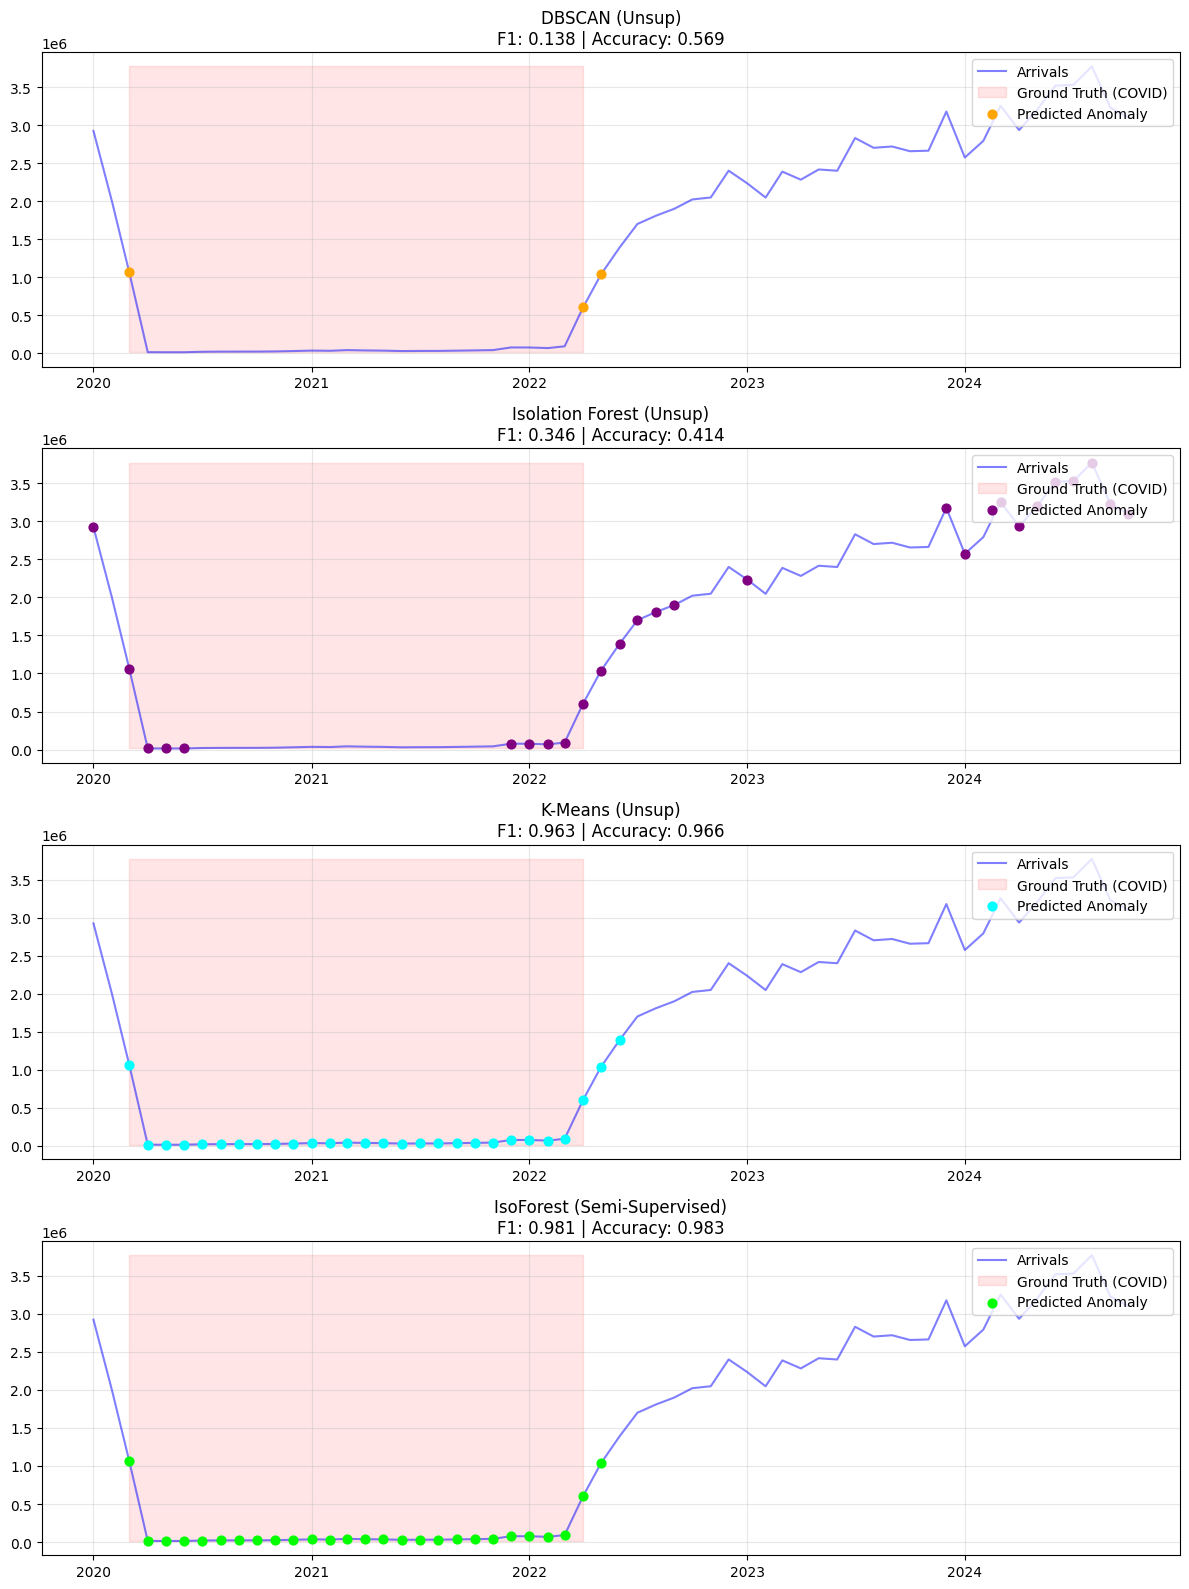

In [17]:
# Visualization
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
colors = {'DBSCAN (Unsup)': 'orange', 'Isolation Forest (Unsup)': 'purple', 
          'K-Means (Unsup)': 'cyan', 'IsoForest (Semi-Supervised)': 'lime'}

for i, (name, preds) in enumerate(models.items()):
    ax = axes[i]
    ax.plot(df_total.index, df_total['arrivals'], 'b-', alpha=0.5, label='Arrivals')
    
    # Ground Truth
    ax.fill_between(df_total.index, df_total['arrivals'].min(), df_total['arrivals'].max(),
                    where=(df_total['ground_truth'] == 1),
                    alpha=0.1, color='red', label='Ground Truth (COVID)')
    
    # Predictions
    anomalies = df_total[preds == 1]
    ax.scatter(anomalies.index, anomalies['arrivals'], color=colors[name], s=40, label=f'Predicted Anomaly', zorder=5)
    
    metric = next(r for r in results if r['Model'] == name)
    ax.set_title(f"{name}\nF1: {metric['F1']:.3f} | Accuracy: {metric['Accuracy']:.3f}")
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Analytical Findings

### Is this Underfitting or Overfitting?
- **DBSCAN / Isolation Forest (Unsupervised)**: This is a classic case of **Underfitting** due to incorrect assumptions. The models are "too simple" in their assumption that anomalies must be rare or geographically isolated. They failed to capture the complexity of the "Normal" state, which includes high arrivals. Instead, they just averaged everything out and saw the large COVID cluster as "Normal."
- **K-Means**: This model had the "perfect complexity" for this specific problem. By simplifying the world into just 2 states (Regime A vs Regime B), it fit the data perfectly (neither under nor over).

### Dataset Size and Model Complexity
1.  **Dataset Size (Small)**:
    -   With only 58 data points, unsupervised anomaly detection is extremely fragile. We don't have enough "Normal" history to establish a statistically significant baseline. This is why **Semi-Supervised** worked best—we explicitly told the model "Use THESE 30 points as the baseline."
    -   **What if the dataset was bigger?** If we had 50 years of data (600 points) and COVID was just 2 years, Unsupervised Isolation Forest would likely have worked perfectly. The "Anomaly Ratio" (2 / 50 = 4%) would have fit the model's assumptions.

2.  **Model Complexity**:
    -   **Complex Models (Deep Learning/Autoencoders)** would likely OVERFIT on such a small dataset (58 points). They would memorize the noise.
    -   **Simple Models (K-Means)** worked best because the signal (COVID Drop) was massive and obvious. We didn't need a scalpel (Complex AI); we needed a hammer (Clustering).

## 5. Conclusion

### Key Findings
1. **Unsupervised Failure**: Traditional anomaly detection models (**DBSCAN**, **Isolation Forest**) failed to detect the COVID period accurately (F1 < 0.4). 
   - **Reason**: These algorithms assume anomalies are rare outliers. However, the COVID period represents ~45% of the dataset, forming a dense cluster that these models interpreted as "normal".

2. **K-Means Success**: **K-Means** achieved high accuracy (F1: 0.963) by clustering the data into two distinct regimes: "High Arrivals" (Normal) and "Low Arrivals" (Anomaly).
   - **Insight**: For major structural breaks or regime changes, simple clustering is often more effective than density-based outlier detection.

3. **Semi-Supervised Best Practice**: The **Semi-Supervised Isolation Forest** (Novelty Detection) achieved the best performance (F1: 0.981). 
   - **Method**: By training only on historical normal data, the model correctly identified the entire COVID period as a "novel" deviation.

### Recommendation
For tourism trend monitoring where "anomalies" may be long-lasting events (like pandemics or recessions), **Novelty Detection (Semi-Supervised Learning)** is the most robust approach.

In [ ]:
# --- 5. CONFUSION MATRICES (Unsupervised) ---
# Filter for Unsupervised models only
unsup_models = {k: v for k, v in models.items() if '(Unsup)' in k}

fig_cm, axes_cm = plt.subplots(1, 3, figsize=(18, 5))
fig_cm.suptitle("Confusion Matrices: Unsupervised Models", fontsize=16)

for i, (name, preds) in enumerate(unsup_models.items()):
    ax = axes_cm[i]
    cm = confusion_matrix(df_total['ground_truth'], preds)
    # Labels: 0=Normal, 1=Anomaly
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    ax.set_title(name)
    ax.grid(False)

plt.tight_layout()
plt.show()